<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5506-pipeline/blob/main/dtsa5506_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex -q
!pip install statsmodels==0.14.0 -q
!pip install tslearn -q
!pip install scikeras -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.0 MB/s eta 0:00:00


In [2]:
# file handling & general
import itertools
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt
import seaborn as sns

# eda
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import pointbiserialr

# pca
from sklearn.decomposition import PCA
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import DBSCAN

# preprocessing & ml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, silhouette_score

from xgboost import XGBRegressor

#
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

# clustering
from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Introduction

The main idea of this project is to predict interest rate changes before they are announced. Interest rates affect nearly everyone and changes to the prevailing rates affect many decisions not just in the long term, but in the short term as well.

The bank of canada exercises counter-inflationary monetary policy by increasing interest to slow inflation, and decreasing interest to allow to avoid recession. To predict changes to the policy interest rate, it would be helpful to first model and predict inflation. The consumer price index is a common measure of inflation, and cpi time series is available from statistics canada.

 Thinking back to when I studied economics as an undergrad, I remember the 2 drivers of inflation being cost-push and demand-pull. In this project I will focus on the cost-push side of things. Intuitively, I think of the inputs to producing goods and services as being materials and wages. For a simple model, the 2 indicators I will use from statistics canada to model cpi are the raw materials price index and average weekly wages.

 Once I have a forcast of cpi, I will use that to make predictions on whether the bank of canada will decrease, hold steady, or increase interest rates.

## Extract, Transform, Load (ETL) pipeline

Statistics Canada has a data cube available to the public, and provides instructions to make http requests [1]. I used these these instructions to request very specific information for specific dates, rather than having to download entire tables. I was able to write code for a single vector request, then spent a lot of time trying to write my own functions before turning to a code generator [2] for the following StatCanETL class.

In [3]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}


In [4]:
class StatCanETL:
    '''ETL pipeline for StatCan data'''

    def __init__(self, table_df):
        '''initialize with df of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''transform the XML response into a structured DataFrame.'''
        # parse XML content
        root = ET.fromstring(xml_content)

        # locate the series element
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        # extract obs
        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # convert date format if quarterly or yearly
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        # convert to df
        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''convert quarterly date string (YYYY-Qx) to a standard date format (YYYY-MM)'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''load df into object named name_df.'''
        variable_name = f'{name}_df'
        globals()[variable_name] = df
        self.data_objects[variable_name] = df
        print(f'Data for {name} saved to object {variable_name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')

In [5]:
# metadata - define what information to pull from statcan
tables = {
    'name': ['wage', 'rmpi', 'cpi', 'rate'],
    'tableid': [14100223, 18100268, 18100004, 10100139],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seasonally adjusted, 2002 = 100', 'bank rate'],
    'vector': ['v79311153', 'v1230998135', 'v41690973', 'v39078'],
    'vectdesc': ['', '', '', ''],
    'description': ['', '', '', ''],
    'frequency': ['monthly', 'monthly', 'monthly', 'daily'],
    'start': ['2001-01', '2001-01', '2001-01', '2001-01-01'], # if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12', '2024-12-31']
}

# make df
table_df = pd.DataFrame(tables)

In [6]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage_df
Processing rmpi...
Data for rmpi saved to object rmpi_df
Processing cpi...
Data for cpi saved to object cpi_df
Processing rate...
Data for rate saved to object rate_df


In [233]:
# rate announcement dates in repo
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5506-pipeline/main/data/rate-announcements.csv'
rate_announcements = pd.read_csv(url)
rate_announcements.head()



,2001-01-23
0,2001-03-06
1,2001-04-17
2,2001-05-29
3,2001-07-17
4,2001-08-28


## EDA and cleaning

In [7]:
# check to see if data loaded correctly
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3), '\n')

wage_df
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14 

rmpi_df
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5 

cpi_df
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1 

rate_df
         Date  Value
0  2001-01-01    6.0
1  2001-01-02    6.0
2  2001-01-03    6.0 



In [8]:
# rename columns
wage_df.rename(columns = {'Value': 'wage',
                          'Date': 'date'},
               inplace = True)
rmpi_df.rename(columns = {'Value': 'rmpi',
                          'Date': 'date'},
               inplace = True)
cpi_df.rename(columns={'Value': 'cpi',
                       'Date': 'date'},
               inplace = True)
rate_df.rename(columns={'Value': 'rate',
                        'Date': 'date'},
               inplace = True)

In [9]:
# merge tables with monthly data
data = wage_df.merge(rmpi_df, on = 'date', how = 'outer') \
              .merge(cpi_df, on = 'date', how = 'outer')

In [10]:
print(data)
print(data.info())

        date     wage   rmpi    cpi
0    2001-01   657.14   65.2   96.3
1    2001-02   653.59   65.8   96.8
2    2001-03   655.14   65.5   97.1
3    2001-04   652.44   65.2   97.8
4    2001-05   652.28   65.3   98.6
..       ...      ...    ...    ...
283  2024-08  1274.25  139.3  161.8
284  2024-09  1277.70  134.8  161.1
285  2024-10  1284.24  140.3  161.8
286  2024-11  1285.91  140.2  161.8
287  2024-12      NaN  142.0  161.2

[288 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    288 non-null    object 
 1   wage    287 non-null    float64
 2   rmpi    288 non-null    float64
 3   cpi     288 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.1+ KB
None


At the time of writing, wage was missing one observation from 2024-12.
I assume this is because it may take a while for the data to be processed each month. I'll use forward fill to deal with that missing value. If quarterly data was pulled from the data cube, there would be missing data for the months 02-03, 05-06, 08-09, and 11-12. Forward fill could also deal with those missing observations.

In [11]:
# fill na
data = data.ffill()

In [12]:
# format date
data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    288 non-null    object 
 1   wage    288 non-null    float64
 2   rmpi    288 non-null    float64
 3   cpi     288 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.1+ KB


In [14]:
# descriptive stats
data.describe()

,wage,rmpi,cpi
count,288.000000,288.000000,288.000000
mean,911.631250,99.128125,123.738542
std,170.097978,24.307042,17.143681
min,652.280000,55.300000,96.300000
25%,772.157500,84.075000,109.775000
50%,903.520000,97.050000,122.200000
75%,1009.597500,112.725000,134.225000
max,1285.910000,166.600000,162.100000


The interest rate data is published (almost) daily, but only changes at 8 pre-determined dates per year. This will require some extra wrangling to align with the other monthly series. Where the rate changes on or before the 15th of the month, I'll apply changed rate to that month. Where the rate changes after the 15th of the month, I'll apply the changed rate to the following month.

In [15]:
print(rate_df.info())
print(rate_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8766 non-null   object 
 1   rate    6231 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.1+ KB
None
              rate
count  6231.000000
mean      2.237963
std       1.519686
min       0.500000
25%       1.000000
50%       1.750000
75%       3.250000
max       6.000000


In [16]:
# date format
rate_df['date'] = pd.to_datetime(rate_df['date'])

# continuous dates
rate_df = rate_df.set_index('date')\
                           .asfreq('D')\
                           .reset_index()

# fill na
rate_df['rate'] = rate_df['rate'].ffill()

In [17]:
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8766 non-null   datetime64[ns]
 1   rate    8766 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.1 KB


In [18]:
def preprocess_rate(rate_df):

    '''
    cleans and transforms daily interest rate df
    to monthly based on the 15th-of-the-month rule.

    args:
        rate_df (pd.DataFrame): DataFrame containing 'date' and 'rate' columns.

    returns:
        pd.DataFrame with monthly interest rates.
    '''

    # sort
    rate_df = rate_df.sort_values('date')

    # id rate changes
    rate_df['prev_rate'] = rate_df['rate'].shift(1)
    rate_df['rate_changed'] = rate_df['rate'] != rate_df['prev_rate']

    # copy df
    rate_changes = rate_df.copy()

    # extract year, month, and day
    rate_df['year'] = rate_df['date'].dt.year
    rate_df['month'] = rate_df['date'].dt.month
    rate_df['day'] = rate_df['date'].dt.day

    #  apply 15th of month rule
    rate_df['effective_month'] = rate_df.apply(
        lambda row: row['month'] if row['day'] <= 15 else (row['month'] % 12 + 1),
        axis=1)

    rate_df['effective_year'] = rate_df.apply(
        lambda row: row['year'] if row['day'] <= 15 else (row['year'] + (row['month'] == 12)),
        axis=1)

    # drop old year and month column
    rate_df.drop(columns = ['year', 'month'],
                      inplace = True)

    # drop duplicates
    rate_df = rate_df.sort_values('date')\
                     .drop_duplicates(subset = ['effective_year',
                                                      'effective_month'],
                                      keep = "last")

    # rename colunms create date col
    rate_df = rate_df.rename(columns = {'effective_year': 'year',
                                              'effective_month': 'month'})
    rate_df['day'] = 1

    # convert datetime
    rate_df['date'] = pd.to_datetime(rate_df[['year', 'month', 'day']])

    # drop cols
    rate_df = rate_df.drop(columns = ['prev_rate', 'rate_changed', 'year', 'month', 'day'])

    # format date
    rate_df['date'] = pd.to_datetime(rate_df['date']).dt.strftime('%Y-%m')

    return rate_df

In [19]:
# preprocess rate_df
rate_df = preprocess_rate(rate_df)

In [20]:
rate_df.head()

,date,rate
14,2001-01,6.00
45,2001-02,5.75
73,2001-03,5.25
104,2001-04,5.25
134,2001-05,5.00


In [21]:
data = data.merge(rate_df, on = 'date', how = 'outer').set_index('date')

In [22]:
data.head()

,wage,rmpi,cpi,rate
date,,,,
2001-01,657.14,65.2,96.3,6.00
2001-02,653.59,65.8,96.8,5.75
2001-03,655.14,65.5,97.1,5.25
2001-04,652.44,65.2,97.8,5.25
2001-05,652.28,65.3,98.6,5.00


#### Scaling the data

Comparing series with different magnitudes can be a bit like comparing apples to oranges, or maybe grapes to watermelons. Scaling the data makes visually comparing the series easier and is also required for some ml models.

In [24]:
scaler = MinMaxScaler
data_scaled = data.copy()
data_scaled[['wage', 'rmpi', 'cpi', 'rate']] = scaler().fit_transform(data[['wage', 'rmpi', 'cpi', 'rate']])
data_scaled.describe()

,wage,rmpi,cpi,rate
count,288.000000,288.000000,288.000000,289.000000
mean,0.409310,0.393784,0.416999,0.319912
std,0.268450,0.218392,0.260542,0.278152
min,0.000000,0.000000,0.000000,0.000000
25%,0.189192,0.258535,0.204787,0.090909
50%,0.396509,0.375112,0.393617,0.227273
75%,0.563921,0.515948,0.576368,0.500000
max,1.000000,1.000000,1.000000,1.000000


Let's have a look at what the plotted data looks like.

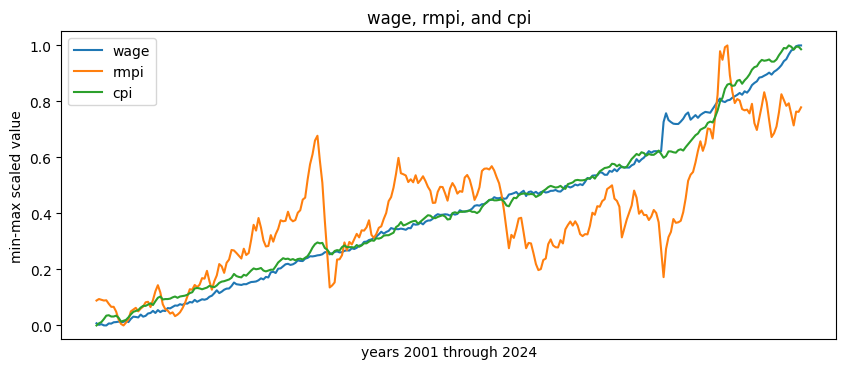

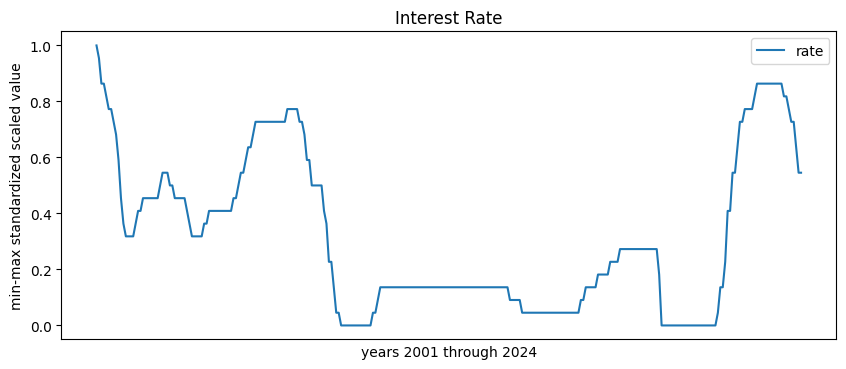

In [26]:
plt.figure(figsize=(10, 4))

for col in data_scaled.columns:
    if col != 'rate':
        plt.plot(data_scaled.index,
                 data_scaled[col],
                 linestyle = '-',
                 label = col)

plt.xlabel('years 2001 through 2024')
plt.xticks([])
plt.ylabel('min-max scaled value')
plt.title('wage, rmpi, and cpi')
plt.legend()
plt.show()

# Separate plot for rate
plt.figure(figsize = (10, 4))
plt.plot(data_scaled.index,
         data_scaled['rate'],
         linestyle = '-',
         label = 'rate')
plt.xlabel('years 2001 through 2024')
plt.xticks([])
plt.ylabel('min-max standardized scaled value')
plt.title('Interest Rate')
plt.legend()
plt.show()

In the first figure above, we can see that wage appears to be closely correlated with the cpi with a nearly-constant upward linear trend. rmpi is relatively more volatile but appears to also follow an upward trend.

### Transforming data with differencing

Description of differencing

In [27]:
data_diff = data.copy().dropna()

In [28]:
data_diff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 2001-01 to 2024-12
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wage    288 non-null    float64
 1   rmpi    288 non-null    float64
 2   cpi     288 non-null    float64
 3   rate    288 non-null    float64
dtypes: float64(4)
memory usage: 11.2+ KB


In [29]:
# adf test for stationarity
adf_result = adfuller(data_diff['cpi'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: 0.7257562584956001
p-value: 0.990338109629542


In [30]:
# hp filter differencing
lambda_value = 10
cycle, trend = hpfilter(data_diff['cpi'], lamb = lambda_value)
data_diff['cpi_cyclical'] = data_diff['cpi'] - trend
data_diff['cpi_trend'] = trend

In [31]:
# standard first order differencing
data_diff['cpi_diff'] = data_diff['cpi'].diff()
data_diff.dropna(inplace = True)

In [32]:
data_diff.head()

,wage,rmpi,cpi,rate,cpi_cyclical,cpi_trend,cpi_diff
date,,,,,,,
2001-02,653.59,65.8,96.8,5.75,-0.109655,96.909655,0.5
2001-03,655.14,65.5,97.1,5.25,-0.273467,97.373467,0.3
2001-04,652.44,65.2,97.8,5.25,0.000203,97.799797,0.7
2001-05,652.28,65.3,98.6,5.00,0.462926,98.137074,0.8
2001-06,656.81,63.9,98.7,4.75,0.366252,98.333748,0.1


In [33]:
# adf test - cpi cyclical
adf_result_c = adfuller(data_diff['cpi_cyclical'])
print(f'adf statistic (cyclical): {adf_result_c[0]}')
print(f'p-value: {adf_result_c[1]}')

adf statistic (cyclical): -9.441346433671818
p-value: 4.885277221583502e-16


In [34]:
# adf test - cpi diff
adf_result = adfuller(data_diff['cpi_diff'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -2.956485504812459
p-value: 0.03916280564842521


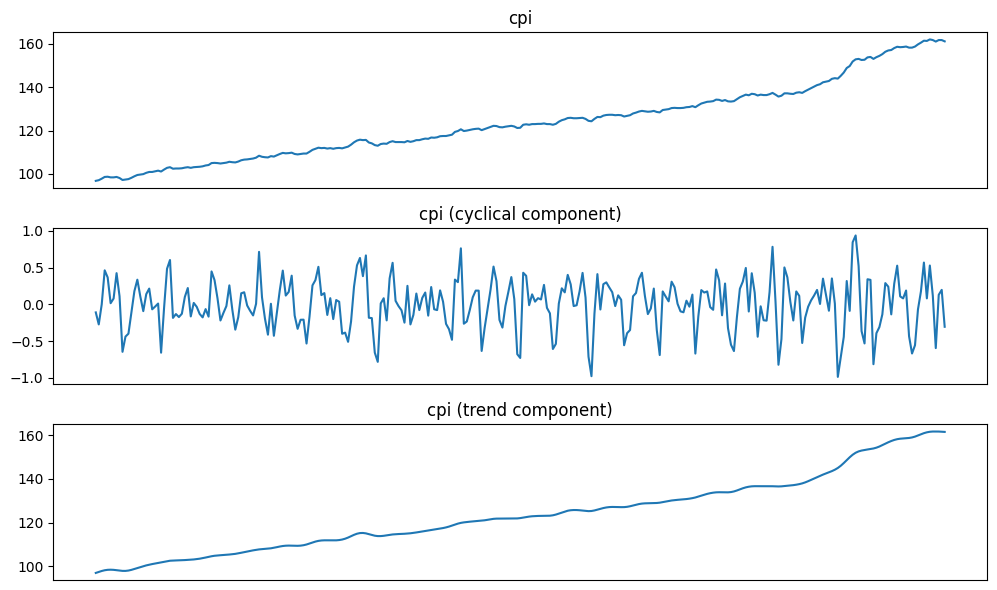

In [39]:
# plot cpi components
fig, axes = plt.subplots(3, 1, figsize=(10, 6))

axes[0].plot(data_diff.index, data_diff['cpi'])
axes[0].set_title('cpi')
axes[0].set_xticks([])

axes[1].plot(data_diff.index,
             data_diff['cpi_cyclical'])
axes[1].set_title('cpi (cyclical component)')
axes[1].set_xticks([])

axes[2].plot(data_diff.index,
             data_diff['cpi_trend'])
axes[2].set_title('cpi (trend component)')
axes[2].set_xticks([])

plt.tight_layout()
plt.show()


In [44]:
# convert index to datetime with frequency for statsmodels
data_diff.index = pd.date_range(start = '2001-01-01',
                                periods = len(data_diff),
                                freq = 'MS')

### ARIMA statistical model of cpi

The auto-regressive integrate moving average model is not a machine learning model, but a statistical model that is frequently used on time series data. It models series based upon its own prior values. Some assumptions of the model:
* stationary data
* sensitive to outliers
* and others...

In [41]:
def evaluate_arima_rmse(data, p_values, d_values, q_values):
    '''
    iterate through (p, d, q) values, fit ARIMA models, compute rmse

    parameters:
        data (pd.Series): ime series
        p_values (list): list of AR terms
        d_values (list): list of differencing terms
        q_values (list): list of MA terms

    Returns:
        results (list of tuples): (p, d, q, rmse)
    '''
    best_score = float('inf')
    results = []

    # Iterate through all combinations of (p, d, q)
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            # fit
            model = ARIMA(data, order=(p, d, q))
            model_fit = model.fit()

            # prediction
            predictions = model_fit.fittedvalues

            # evaluate
            rmse = np.sqrt(mean_squared_error(data[d:], predictions[d:]))  # Align differenced series


            # results
            results.append((p, d, q, rmse))

            # best model
            if rmse < best_score:
                best_score = rmse
                best_cfg = (p, d, q)

            print(f'arima({p},{d},{q}) - rmse: {rmse:.4f}')

        except Exception as e:
            print(f'arima({p},{d},{q}) failed: {e}')
            continue

    # results to df
    results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'RMSE']).sort_values(by='RMSE')

    print('\nbest model:', best_cfg, 'with rmse:, best_score')

    return results_df

In [ ]:
# train & test - original
# train_data = data_diff['2021-01-01':'2023-12-31']['cpi']
# test_data = data_diff['2024-01-01':'2024-12-31']['cpi']

In [45]:
# train & test data - cyclical
train_arima_cyclical = data_diff['2001-01-01':'2023-12-31']['cpi_cyclical']
test_arima_cyclical = data_diff['2024-01-01':'2024-12-31']['cpi_cyclical']

In [ ]:
# train & test data - diff
# train_arima_diff = data_diff['2001-01-01':'2023-12-31']['cpi_diff']
# test_arima_diff = data_diff['2024-01-01':'2024-12-31']['cpi_diff']

In [46]:
warnings.filterwarnings('ignore', message = 'Non-stationary starting autoregressive parameters')
warnings.filterwarnings('ignore', message = 'Non-invertible starting MA parameters found.')
warnings.filterwarnings('ignore', message = 'Maximum Likelihood optimization failed to ')

# parameters to search
p_values = [1, 2, 3, 6, 12]
d_values = [0, 1]
q_values = [1, 2, 3, 6, 12]
df = train_arima_cyclical

arima_results = evaluate_arima_rmse(df, p_values, d_values, q_values)



arima(1,0,1) - rmse: 0.3007
arima(1,0,2) - rmse: 0.2692
arima(1,0,3) - rmse: 0.2619
arima(1,0,6) - rmse: 0.2606
arima(1,0,12) - rmse: 0.2315
arima(1,1,1) - rmse: 0.3145
arima(1,1,2) - rmse: 0.3035
arima(1,1,3) - rmse: 0.2974
arima(1,1,6) - rmse: 0.2626
arima(1,1,12) - rmse: 0.2425
arima(2,0,1) - rmse: 0.2549
arima(2,0,2) - rmse: 0.2330
arima(2,0,3) - rmse: 0.2690
arima(2,0,6) - rmse: 0.2598
arima(2,0,12) - rmse: 0.2343
arima(2,1,1) - rmse: 0.2979
arima(2,1,2) - rmse: 0.2599
arima(2,1,3) - rmse: 0.2974
arima(2,1,6) - rmse: 0.2673
arima(2,1,12) - rmse: 0.2378
arima(3,0,1) - rmse: 0.2548
arima(3,0,2) - rmse: 0.2525
arima(3,0,3) - rmse: 0.2586
arima(3,0,6) - rmse: 0.2598
arima(3,0,12) - rmse: 0.2343
arima(3,1,1) - rmse: 0.2974
arima(3,1,2) - rmse: 0.2934
arima(3,1,3) - rmse: 0.2610
arima(3,1,6) - rmse: 0.2943
arima(3,1,12) - rmse: 0.2338
arima(6,0,1) - rmse: 0.2401
arima(6,0,2) - rmse: 0.2394
arima(6,0,3) - rmse: 0.2448
arima(6,0,6) - rmse: 0.2315
arima(6,0,12) - rmse: 0.2280
arima(6,1,1) 

In [47]:
# model
arima_model = sm.tsa.ARIMA(train_arima_cyclical,
                           order = (12, 0, 12))

# fit
arima_fit = arima_model.fit()

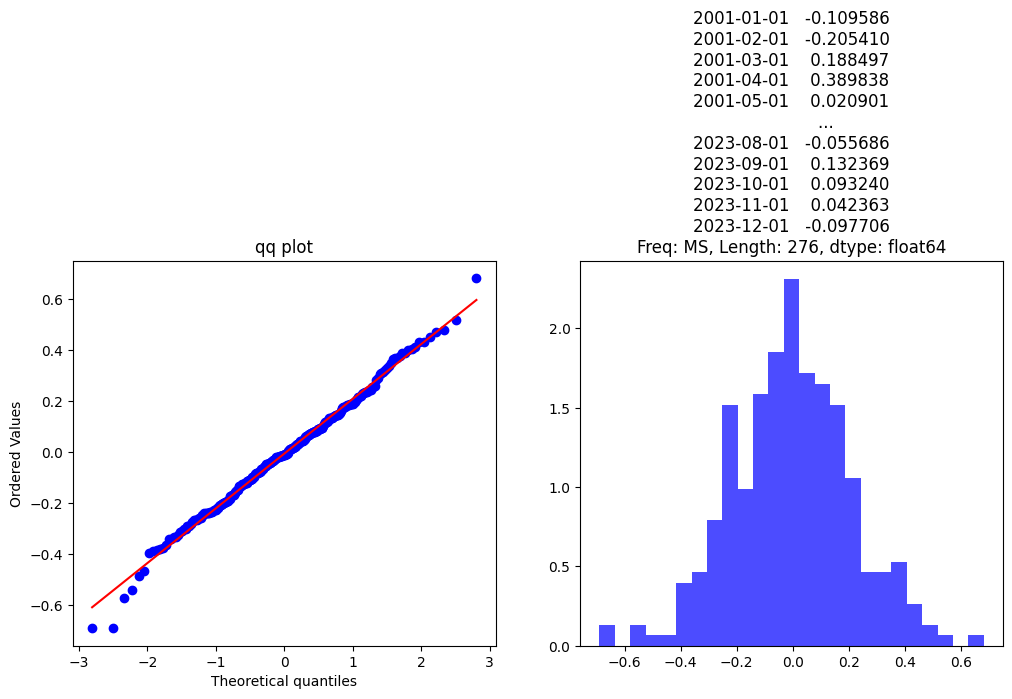

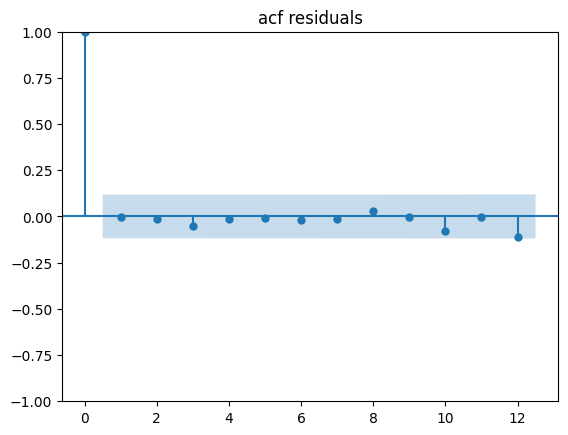

In [48]:
# residuals
residuals = arima_fit.resid

# plot hist and qq
fig, ax = plt.subplots(1,
                       2,
                       figsize = (12, 5))

stats.probplot(residuals,
               plot = ax[0])
ax[0].set_title('qq plot')

ax[1].hist(residuals,
           bins = 25,
           density = True,
           alpha = 0.7,
           color = 'blue')
ax[1].set_title(residuals)

plt.show()

# acf plot
sm.graphics.tsa.plot_acf(residuals,
                         lags = 12)
plt.title('acf residuals')
plt.show()

QQ plot doesn't look too bad, distribution or residuals looks relatively normal, and no autocorrelation in residuals. I think it's close enough for demonstrative purposes.

RMSE: 0.3188978703084262
MAE: 0.22516922011045828


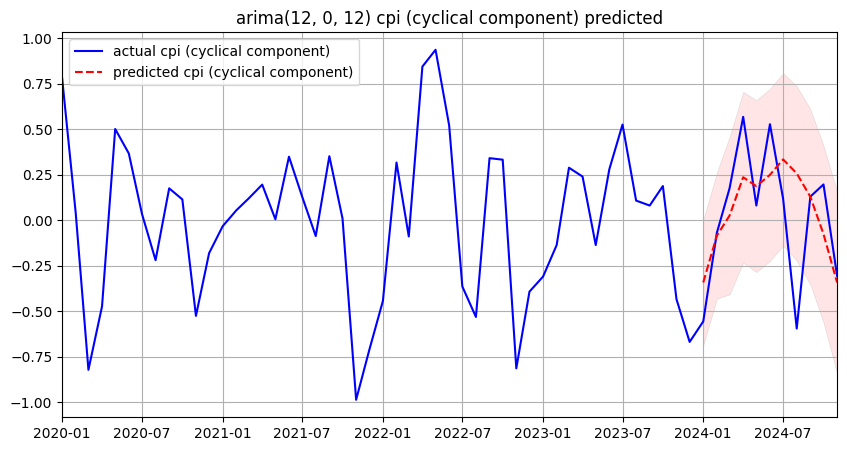

In [49]:
# pred on test data
forecast_test = arima_fit.get_forecast(steps = len(test_arima_cyclical))
predictions = forecast_test.predicted_mean
conf_int = forecast_test.conf_int(alpha = 0.10)

# evaluate
rmse = np.sqrt(mean_squared_error(test_arima_cyclical,
                                  predictions))
mae = mean_absolute_error(test_arima_cyclical,
                          predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# plot
plt.figure(figsize=(10, 5))
plt.plot(data_diff.index,
         data_diff['cpi_cyclical'],
         label = 'actual cpi (cyclical component)',
         color = 'blue')
plt.plot(test_arima_cyclical.index,
         predictions,
         label = 'predicted cpi (cyclical component)',
         color = 'red',
         linestyle = 'dashed')
plt.fill_between(test_arima_cyclical.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color = 'red',
                 alpha = 0.10,
                 edgecolor = 'black',
                 linewidth = 0.5)
plt.legend()
plt.title('arima(12, 0, 12) cpi (cyclical component) predicted')
plt.xlim(pd.to_datetime('2020-01-01'), data_diff.index[-1])
plt.grid(True)

plt.show()

Now that I have a model, lets forcast cpi for the next 6 months.

                 date  cpi_cyclical_forecast
2024-01-01 2024-12-01              -0.342209
2024-02-01 2025-01-01              -0.084293
2024-03-01 2025-02-01               0.025708
2024-04-01 2025-03-01               0.236483
2024-05-01 2025-04-01               0.187444
2024-06-01 2025-05-01               0.249852


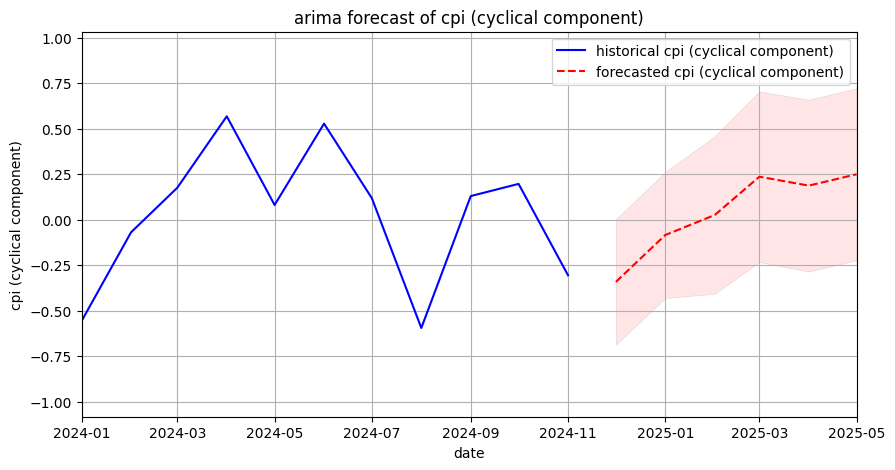

In [50]:
# last date
last_date = data_diff.index[-1]

# create future dates
future_dates = pd.date_range(start = last_date + pd.DateOffset(months = 1),
                             periods = 6,
                             freq = 'MS')


# forecast
forecast_future = arima_fit.get_forecast(steps = 6)
predictions_future = forecast_future.predicted_mean
conf_int_future = forecast_future.conf_int(alpha = 0.10)

forecast_df = pd.DataFrame({'date': future_dates,
                            'cpi_cyclical_forecast': predictions_future})

print(forecast_df)

# plot
plt.figure(figsize=(10, 5))

plt.plot(data_diff.index,
         data_diff['cpi_cyclical'],
         label = 'historical cpi (cyclical component)',
         color = 'blue')

plt.plot(forecast_df['date'],
         forecast_df['cpi_cyclical_forecast'],
         label = 'forecasted cpi (cyclical component)',
         color = 'red',
         linestyle = 'dashed')


plt.fill_between(forecast_df['date'],
                  conf_int_future.iloc[:, 0],
                  conf_int_future.iloc[:, 1],
                  color='red',
                  alpha=0.10,
                  edgecolor='black',
                  linewidth=0.5)

plt.legend()
plt.title('arima forecast of cpi (cyclical component)')
plt.xlabel('date')
plt.ylabel('cpi (cyclical component)')
plt.grid(True)

plt.xlim(pd.to_datetime('2024-01-01'), forecast_df['date'].max())

plt.show()

## Machine learning models

### Feature engineering

In [51]:
data_scaled.head()

,wage,rmpi,cpi,rate
date,,,,
2001-01,0.007670,0.088949,0.000000,1.000000
2001-02,0.002067,0.094340,0.007599,0.954545
2001-03,0.004514,0.091644,0.012158,0.863636
2001-04,0.000253,0.088949,0.022796,0.863636
2001-05,0.000000,0.089847,0.034954,0.818182


In [171]:
ml_df = data_scaled.copy()
ml_df = ml_df.reset_index()

#### Target feature

In [172]:
# categorical target - rate_change
ml_df['rate_diff'] = ml_df['rate'].diff().fillna(0)
ml_df['rate_change'] = ml_df['rate_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

In [173]:
ml_df['rate_change'].unique()

array([ 0, -1,  1])

#### X features

In [174]:
ml_df['date'] = pd.to_datetime(ml_df['date'])

In [175]:
# date features
ml_df['year'] = ml_df['date'].dt.year
ml_df['month'] = ml_df['date'].dt.month
ml_df['quarter'] = ml_df['date'].dt.quarter

In [176]:
# cpi lag features - months
ml_df['cpi_lag3'] = ml_df['cpi'].shift(3)
ml_df['cpi_lag6'] = ml_df['cpi'].shift(6)
ml_df['cpi_lag9'] = ml_df['cpi'].shift(9)
ml_df['cpi_lag12'] = ml_df['cpi'].shift(12)

In [177]:
# cpi rolling window - mean
ml_df['cpi_rolling_mean3'] = ml_df['cpi'].rolling(window = 3).mean()
ml_df['cpi_rolling_mean6'] = ml_df['cpi'].rolling(window = 6).mean()
ml_df['cpi_rolling_mean9'] = ml_df['cpi'].rolling(window = 9).mean()

In [178]:
# cpi exp. moving avg - ema
ml_df['cpi_ema3'] = ml_df['cpi'].ewm(span = 3).mean()
ml_df['cpi_ema6'] = ml_df['cpi'].ewm(span = 6).mean()
ml_df['cpi_ema9'] = ml_df['cpi'].ewm(span = 9).mean()

In [179]:
# cpi rate of change
ml_df['cpi_pct_change3'] = ml_df['cpi'].pct_change(periods = 3)
ml_df['cpi_pct_change6'] = ml_df['cpi'].pct_change(periods = 6)
ml_df['cpi_pct_change9'] = ml_df['cpi'].pct_change(periods = 9)
ml_df['cpi_pct_change12'] = ml_df['cpi'].pct_change(periods = 12) # year over year change.

<ipython-input-179-13439c08ff64>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['cpi_pct_change3'] = ml_df['cpi'].pct_change(periods = 3)
<ipython-input-179-13439c08ff64>:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['cpi_pct_change6'] = ml_df['cpi'].pct_change(periods = 6)
<ipython-input-179-13439c08ff64>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ml_df['cpi_pct_change9'] = ml

In [208]:
# replace infinite values with nan from pct change feature creation
for feature in features:
    ml_df[feature] = ml_df[feature].replace([np.inf, -np.inf], np.nan)
    ml_df[feature] = ml_df[feature].fillna(ml_df[feature].mean())

In [180]:
# cpi volatility
ml_df['cpi_rolling_std3'] = ml_df['cpi'].rolling(window = 3).std()
ml_df['cpi_rolling_std6'] = ml_df['cpi'].rolling(window = 6).std()

In [181]:
ml_df['cpi_diff_rolling_mean3'] = ml_df['cpi'] - ml_df['cpi_rolling_mean3']
ml_df['cpi_diff_rolling_mean6'] = ml_df['cpi'] - ml_df['cpi_rolling_mean6']

In [182]:
# inflation deviation
ml_df['inflation_dev'] = ml_df['cpi_change_yoy'] - 2
ml_df['inflation_dev_lag3'] = ml_df['inflation_dev'].shift(3)
ml_df['inflation_dev_lag6'] = ml_df['inflation_dev'].shift(6)
ml_df['inflation_dev_lag9'] = ml_df['inflation_dev'].shift(9)

In [183]:
# inflation trend - stabilizing or worsening?
ml_df['inflation_trend'] = ml_df['inflation_dev'].diff()
ml_df['inflation_trend_lag3'] = ml_df['inflation_trend'].shift(3)
ml_df['inflation_trend_lag6'] = ml_df['inflation_trend'].shift(6)
ml_df['inflation_trend_lag9'] = ml_df['inflation_trend'].shift(9)

In [184]:
# rmpi features
ml_df['rmpi_lag3'] = ml_df['rmpi'].shift(3)
ml_df['rmpi_lag6'] = ml_df['rmpi'].shift(6)
ml_df['rmpi_lag9'] = ml_df['rmpi'].shift(9)

In [185]:
# rate difference lag
ml_df['rate_diff_lag3'] = ml_df['rate_diff'].shift(3)
ml_df['rate_diff_lag6'] = ml_df['rate_diff'].shift(6)
ml_df['rate_diff_lag9'] = ml_df['rate_diff'].shift(9)

In [186]:
ml_df.dropna(inplace=True)

In [187]:
ml_df.columns

Index(['date', 'wage', 'rmpi', 'cpi', 'rate', 'rate_diff', 'rate_change',
       'year', 'month', 'quarter', 'cpi_lag3', 'cpi_lag6', 'cpi_lag9',
       'cpi_lag12', 'cpi_rolling_mean3', 'cpi_rolling_mean6',
       'cpi_rolling_mean9', 'cpi_ema3', 'cpi_ema6', 'cpi_ema9',
       'cpi_pct_change3', 'cpi_pct_change6', 'cpi_pct_change9',
       'cpi_change_yoy', 'cpi_rolling_std3', 'cpi_rolling_std6',
       'cpi_diff_rolling_mean3', 'cpi_diff_rolling_mean6', 'inflation_dev',
       'inflation_dev_lag3', 'inflation_dev_lag6', 'inflation_dev_lag9',
       'inflation_trend', 'inflation_trend_lag3', 'inflation_trend_lag6',
       'inflation_trend_lag9', 'rmpi_lag3', 'rmpi_lag6', 'rmpi_lag9',
       'rate_diff_lag3', 'rate_diff_lag6', 'rate_diff_lag9'],
      dtype='object')

#### Feature selection

In [224]:
features = [
            #'wage',
            #'rmpi',
            #'cpi',
            #'rate',
            #'rate_diff',
            #'rate_change', #target
            'year',
            'month',
            'quarter',
            'cpi_lag3',
            'cpi_lag6',
            'cpi_lag9',
            'cpi_lag12',
            'cpi_rolling_mean3',
            'cpi_rolling_mean6',
            'cpi_rolling_mean9',
            'cpi_ema3',
            'cpi_ema6',
            'cpi_ema9',
            'cpi_pct_change3',
            #'cpi_pct_change6',
            #'cpi_pct_change9',
            'cpi_pct_change12',
            'cpi_rolling_std3',
            'cpi_rolling_std6',
            'cpi_diff_rolling_mean3',
            #'cpi_diff_rolling_mean6', #multicollinearity
            #'inflation_dev',
            'inflation_dev_lag3',
            'inflation_dev_lag6',
            'inflation_dev_lag9',
            #'inflation_trend',
            'inflation_trend_lag3',
            'inflation_trend_lag6',
            'inflation_trend_lag9',
            'rmpi_lag3',
            'rmpi_lag6',
            'rmpi_lag9',
            'rate_diff_lag3',
            'rate_diff_lag6',
            'rate_diff_lag9'
            ]

In [209]:
correlations = {feature: pointbiserialr(ml_df[feature],
                                        ml_df['rate_change'])[0] for feature in features}
corr_df = pd.DataFrame.from_dict(correlations,
                                 orient = 'index',
                                 columns = ['correlation'])
corr_df = corr_df.abs().sort_values(by = 'correlation',
                                    ascending = False)

corr_df.head(10)

,correlation
rate_diff_lag3,0.310235
cpi_rolling_std6,0.164557
cpi_diff_rolling_mean3,0.148334
cpi_pct_change3,0.147339
rate_diff_lag9,0.141559
rate_diff_lag6,0.129213
inflation_dev_lag3,0.103881
inflation_dev_lag9,0.077496
rmpi_lag3,0.074931
cpi_rolling_std3,0.067656


In [218]:
top_9_features = corr_df.head(9).index.tolist()
top_9_features

['rate_diff_lag3',
 'cpi_rolling_std6',
 'cpi_diff_rolling_mean3',
 'cpi_pct_change3',
 'rate_diff_lag9',
 'rate_diff_lag6',
 'inflation_dev_lag3',
 'inflation_dev_lag9',
 'rmpi_lag3']

In [219]:
ml_df_9 = ml_df[top_9_features + ['rate_change']]

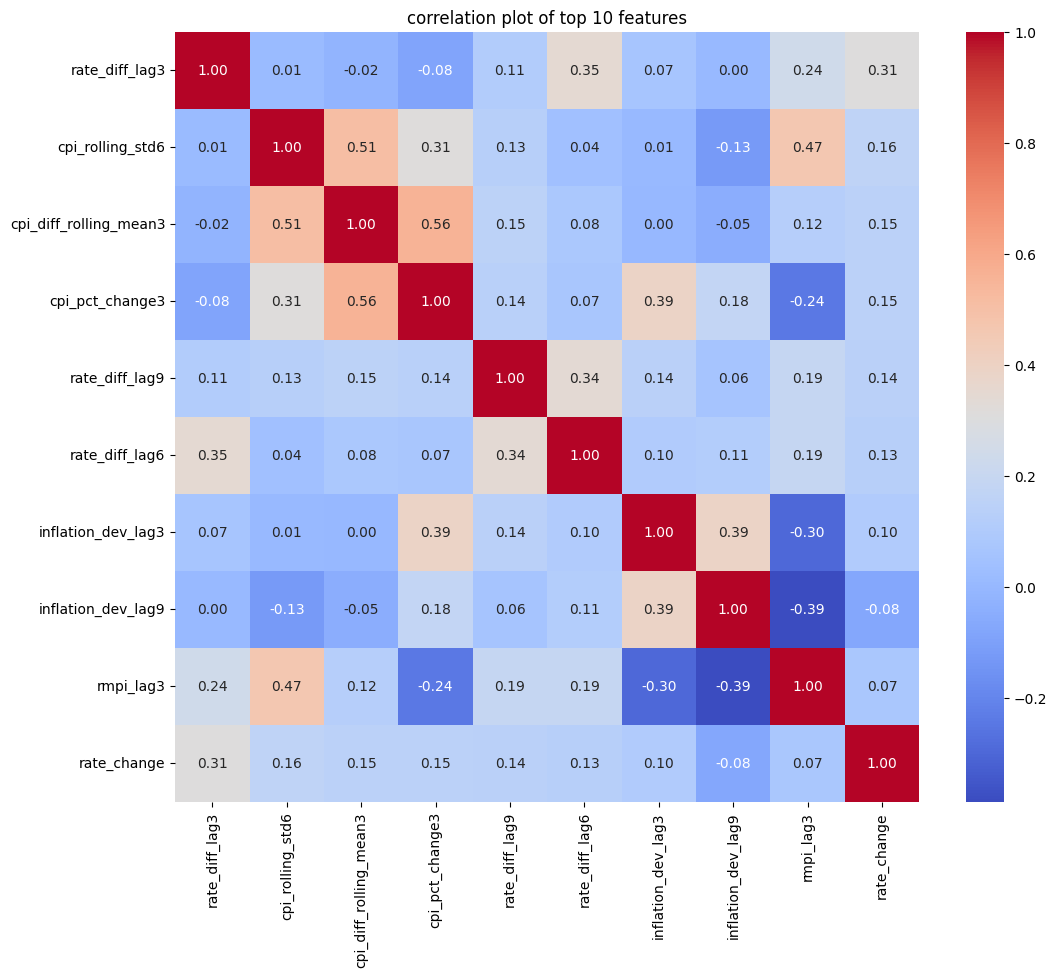

In [220]:
# cross correlation
corr_matrix = ml_df_9.corr()

# plot
plt.figure(figsize = (12, 10))
sns.heatmap(corr_matrix,
            annot = True,
            cmap = 'coolwarm',
            fmt = '.2f')
plt.title('correlation plot of top 10 features')
plt.show()


In [221]:
# split data
train_ml = ml_df[(ml_df['date'] >= '2002-01-01') & (ml_df['date'] <= '2023-12-01')]
test_ml = ml_df[(ml_df['date'] >= '2024-01-01') & (ml_df['date'] <= '2024-12-31')]

In [222]:
# train test
X_train = train_ml[top_9_features]
y_train = train_ml['rate_change']

X_test = test_ml[top_9_features]
y_test = test_ml['rate_change']

In [223]:
model = LogisticRegression(max_iter = 1000)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# eval
mse = mean_squared_error(y_test, y_pred)
print(f'mse: {mse}')

mse: 0.4166666666666667


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


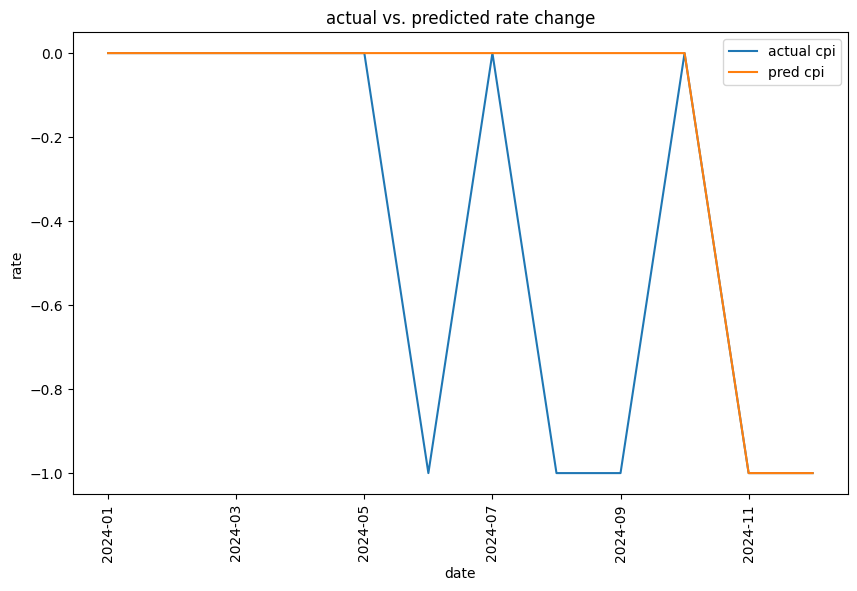

In [ ]:
# plot actual vs pred
plt.figure(figsize = (10, 6))

# years for xaxis lab
x_tick_labels = test_ml['date'].dt.strftime('%Y-%m')

plt.plot(range(len(y_test)),
         y_test.values,
         label = 'actual cpi')
plt.plot(range(len(y_test)),
         y_pred,
         label = 'pred cpi')

plt.xlabel('date')
plt.xticks(range(len(y_test))[::2],
           x_tick_labels[::2],
           rotation = 90)

plt.ylabel('rate')
plt.title('actual vs. predicted rate change')
plt.legend()
plt.show()

### XGB regression

mse: 0.027472863539391157 

r-sqr: -0.7786634274486801


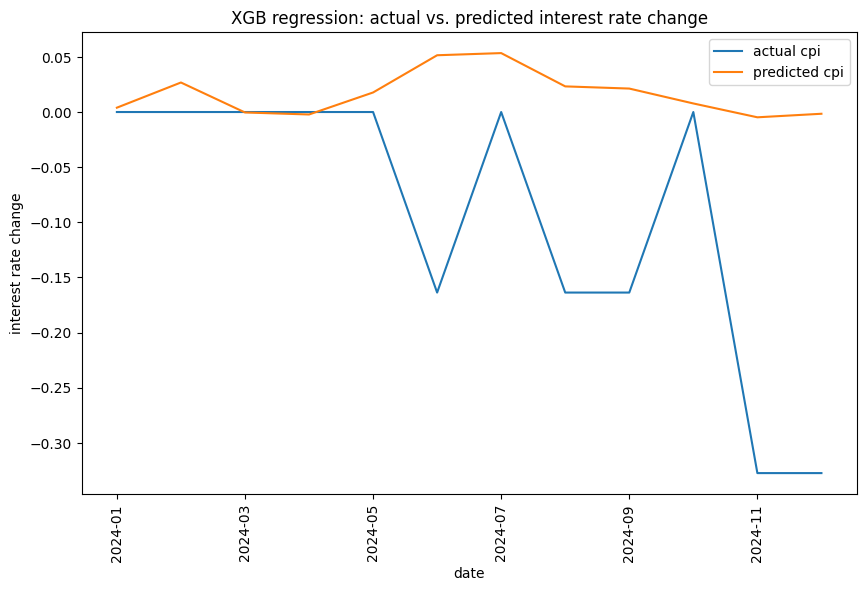

In [ ]:
# init
model = XGBRegressor()

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# eval
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'mse: {mse} \n')
print(f'r-sqr: {r2}')

# plot
plt.figure(figsize=(10, 6))

# years for xaxis lab
x_tick_labels = test_ml['date'].dt.strftime('%Y-%m')

plt.plot(range(len(y_test)),
         y_test.values,
         label = 'actual cpi')
plt.plot(range(len(y_test)),
         y_pred,
         label = 'predicted cpi')

plt.xlabel('date')
plt.xticks(range(len(y_test))[::2],
           x_tick_labels[::2],
           rotation = 90)

plt.ylabel('interest rate change')
plt.title('XGB regression: actual vs. predicted interest rate change')
plt.legend()
plt.show()

RNN model

In [ ]:
# prompt: create an rnn to predict rate_change

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming 'ml_df' is your preprocessed DataFrame with 'rate_change' as the target
# and numerical features

# Prepare the data for the RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is 'rate_change'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12 # Example sequence length (adjust as needed)

# Scale the features (important for RNNs)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(ml_df[numerical_features + ['rate_change']])

# Split the data into train and test sets
train_size = int(len(scaled_features) * 0.8) # Example split (adjust as needed)
train_data = scaled_features[:train_size]
test_data = scaled_features[train_size:]

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))


# Build the RNN model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train,
          epochs = 50,
          batch_size = 32,
          verbose = 0)


# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred),len(numerical_features))),y_pred),axis=1))[:,-1]
y_test = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test),len(numerical_features))),np.expand_dims(y_test,axis=1)),axis=1))[:,-1]


# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

#Further analysis or plotting can be performed here


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
RMSE: 0.1891467704685895


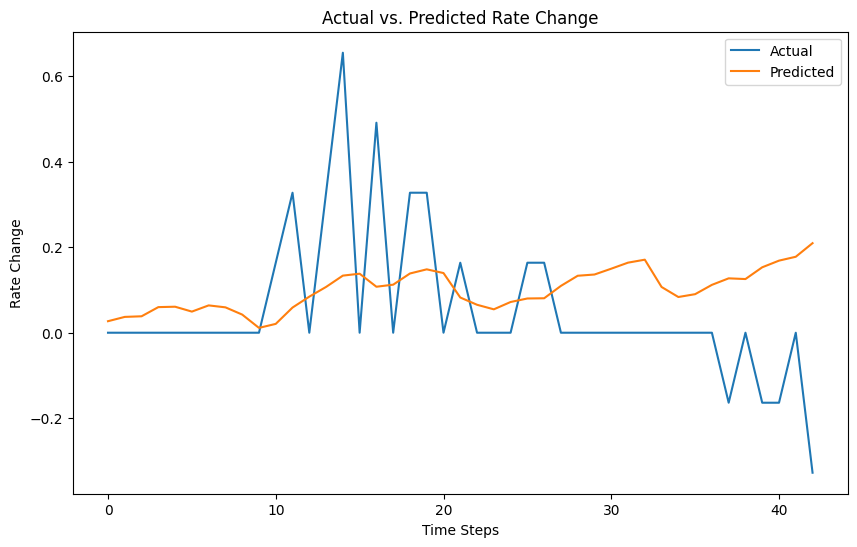

In [ ]:
# prompt: plot actual vs predicted results

import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from the previous code
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Rate Change')
plt.title('Actual vs. Predicted Rate Change')
plt.legend()
plt.show()


None of those models seemed to work very well. lol. It was a good exercise in mining data from Statistics Canada at least.

## Discussion

Further study:
* model raw materials pricing index (rmpi) - it's an important feature. Gaining further understanding of the index, what the materials are and from where they are sourced. Armed with that information, an analyst could watch the news for natural disasters or political unrest experienced both domestically and with international trade partner regions.

* add more series to ETL pipeline:
  * housing market indicators
  * consumer and business confidence
  * exchange rate (import/export/commodity markets)
  * unemployment rate
  * gdp
  * A very large number of features could be engineered from these few series. Just as I modelled cpi, each one could be modelled with other predictors.

* More domain knowledge. While I have a background in economics, I didn't spend much time reading up on economic models for this project due to time constraints. The models created here probably need a lot of refining before they could to be used in production.

## References

*   List item
*   List item

